In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import pickle
# from line_profiler import LineProfiler
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import shuffle
# from scipy import stats
import matplotlib.pyplot as plt
import json
from pfam2go import pfam2go 
from typing import Iterable, Optional
warnings.filterwarnings("ignore")

### Required Physicochemical Properties

Most sources can be found on AAindex

PKA source: D.R. Lide, Handbook of Chemistry and Physics, 72nd Edition, CRC Press, Boca Raton, FL, 1991. (Sigma Aldrich website)

EIIP: Electron-ion interaction potential (Veljkovic et al., 1985)

LEP: No citation, sorta implicit (NOT VERIFIED!)

Wiener Index: ?

Molecular Mass: Wikipedia, implicit

In [2]:
AMINO_ACID_INDICES = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 
                      'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

PKA_AMINO_GROUP = np.array([9.69, 9.04, 8.80, 9.60, 10.28, 9.13, 9.67, 9.60, 9.17, 9.60,
                            9.60, 8.95, 9.21, 9.13, 10.60, 9.15, 9.10, 9.39, 9.11, 9.62])
PKA_CARBOXYL_GROUP = np.array([2.34, 2.17, 2.02, 1.88, 1.96, 2.17, 2.19, 2.34, 1.82, 2.36,
                               2.36, 2.18, 2.28, 1.83, 1.99, 2.21, 2.09, 2.83, 2.20, 2.32])
EIIP = np.array([0.03731, 0.09593, 0.00359, 0.12630, 0.08292, 0.07606, 0.00580, 0.00499, 0.02415, 0.0000, 
                 0.0000, 0.03710, 0.08226, 0.09460, 0.01979, 0.08292, 0.09408, 0.05481, 0.05159, 0.00569])
LONE_ELECTRON_PAIRS = np.array([0, 0, 1, 2, 1, 1, 2, 0, 1, 0, 
                                0, 0, 0, 0, 0, 1, 1, 0, 1, 0])
WIENER_INDEX = np.array([0.3466, 0.1156, 0.3856, 0.2274, 0.0501, 0.6379, 0.1938, 0.1038, 0.2013,
                       0.2863, 0.1071, 0.7767, 0.7052, 0.3419, 0.0957, 0.4375, 0.9320, 0.1000, 0.1969, 0.9000])
MOLECULAR_MASS = np.array([89.094, 174.203, 132.119, 133.104, 121.154, 146.146, 147.131, 75.067, 155.156, 131.175,
                           131.175, 146.189, 149.208, 165.192, 115.132, 105.093, 119.119, 204.228, 181.191, 117.148])

PP_LIST = [PKA_AMINO_GROUP, PKA_CARBOXYL_GROUP, EIIP, LONE_ELECTRON_PAIRS, WIENER_INDEX, MOLECULAR_MASS]

In [3]:
# Amino Acid Composition (AAC) groups - Polarity Charge
# C1; C2; C3; C4 
# (polar amino acid with positive charge, polar amino acid with negative charge, noncharged
# polar amino acid, nonpolar amino acid).

AAC_C1 = ['G', 'A', 'V', 'L', 'I', 'F', 'W', 'M', 'P']
AAC_C2 = ['S', 'T', 'C', 'Y', 'N', 'Q']
AAC_C3 = ['D', 'E']
AAC_C4 = ['R', 'K', 'H']

AAC_C_LIST = [AAC_C1, AAC_C2, AAC_C3, AAC_C4]

# Amino Acid Composition (AAC) groups - Hydrohpobicity
# H1;H2;H3;H4  (strong hydrophobic residue, weak hydrophobic residue, strong hydrophilic residue, weak hydrophilic residue).
# This scale is obtained from Kyte and Doolittle (1982). 
# K&D scale from 0 to +-2.0 is considered weak, >2.0 is strong hydrophobicity, and <-2.0 is strong hydrophilic. 


AAC_H1 = ['I', 'V', 'L', 'F', 'C']
AAC_H2 = ['M', 'A']
AAC_H3 = ['H', 'Q', 'N', 'E', 'D', 'K', 'R']
AAC_H4 = ['G', 'T', 'S', 'W', 'Y', 'P']

AAC_H_LIST = [AAC_H1, AAC_H2, AAC_H3, AAC_H4]


### GO Terms List 

The json file provides a list of GO terms that are potentially invovled in DNA-binding

Most are descendants of DNA-binding ("GO:0003677") and DNA-binding transcription factor activity ("DNA-binding transcription factor activity")

In [4]:
DNA_BINDING_GO_TERM_LIST = json.load(open("descendant_ids.json", "r"))

#### PP Matrix stored as a constant

In [5]:
# rows: normalized pp properties 
# columns: amino acids
def create_pp_matrix() -> np.ndarray:
    pp_matrix = np.empty((len(PP_LIST), len(AMINO_ACID_INDICES)), dtype=float)
    for i, pp in enumerate(PP_LIST):
        max_val = np.max(pp)
        min_val = np.min(pp)
        pp_matrix[i] = (pp - min_val) / (max_val - min_val)
    
    return pp_matrix

# Constant PP_MATRIX
PP_MATRIX = create_pp_matrix()
# print(PP_MATRIX)

### OBV

Source: Shen, Juwen, et al. "Predicting protein–protein interactions based only on sequences information." Proceedings of the National Academy of Sciences 104.11 (2007): 4337-4341. (Supp. information)


In [6]:
obv_classes = {
    'A' : 0, 'G' : 0, 'V' : 0,
    'I': 1, 'L': 1, 'F': 1, 'P': 1,
    'Y': 2, 'M': 2, 'T': 2, 'S': 2,
    'H': 3, 'N': 3, 'Q': 3, 'W': 3,
    'R': 4, 'K': 4,
    'D': 5, 'E': 5,
    'C': 6
}

def generate_obv(amino_acid):
    temp = np.zeros(7)
    temp[obv_classes.get(amino_acid)] = 1
    return temp

### Get Window Instance from sequence

In [7]:
# takes in a string, then 
# extract list of instances by sliding a window through the sequence
def get_instances_from_seq(seq : str, window_size : int = 9) -> list :
    instances = list()
    for i in range(len(seq) - window_size + 1):
        instances.append(seq[i:i+window_size])
    return instances
    

## Generate PSSM-PP

In [8]:
"""Generate PSSM using psiblast from a given sequence."""
def generate_pssm(input_seq: str, num_iterations = 3) -> np.ndarray:
    DB_PATH = "./databases/uniprot_sprot.fasta"
    output_pssm = "output.pssm"

    # Creating a temporary fasta file for input
    with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".fasta") as temp_fasta:
        SeqIO.write([SeqRecord(Seq(input_seq))], temp_fasta, "fasta")
        temp_fasta_path = temp_fasta.name

    # Running psiblast
    try:
        subprocess.run(["psiblast", "-query", temp_fasta_path, "-db", DB_PATH, 
                        "-out_ascii_pssm", output_pssm, "-num_iterations", str(num_iterations), "-evalue", "0.001"], 
                        check=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    finally:
        os.remove(temp_fasta_path)

    # Reading PSSM output
    try:
        pssm_df = pd.read_csv(output_pssm, delim_whitespace=True, skiprows=3, header=None)
        os.remove(output_pssm)  # Clean up PSSM file after reading
        pssm_array = pssm_df.iloc[:-5, 2:22].to_numpy(dtype=int)
        return pssm_array
    except FileNotFoundError:
        print(f"Error: PSSM file not found. Input Sequence: {input_seq}")
        return None
    

# Rescale pssm using sigmoid
def rescale_pssm(input_pssm) -> np.ndarray:
    input_pssm = 1/(1 + np.exp(-input_pssm))
    return input_pssm

# Get only the pssm rows that are relevant to the sequence
def get_sliced_pssm(original_pssm : np.ndarray, start_index : int, window_size : int = 9):
    return original_pssm[start_index : start_index + window_size, :]

def create_pssm_pp(pssm_matrix : np.ndarray, pp_matrix : np.ndarray) -> np.ndarray:
    pssm_matrix = np.array(pssm_matrix, dtype=float)
    return pp_matrix @ pssm_matrix

# generate_pssm("KPKNKDKDKKVPEPDNKKKKPKKEEEQKWKWWEEERYPEGIKWKFLEHKGPVFAPPYEPLPENVKFYYDGKVMKLSPKAEEVATFFAKMLDHEYTTKEIFRKNFFKDWRKEMTNEEKNIITNLSKCDFTQMSQYFKAQTEARKQMSKEEKLKIKEENEKLLKEYGFCIMDNHKERIANFKIEPPGLFRGRGNHPKMGMLKRRIMPEDIIINCSKDAKVPSPPPGHKWKEVRHDNKVTWLVSWTENIQGSIKYIMLNPSSRIKGEKDWQKYETARRLKKCVDKIRNQYREDWKSKEMKVRQRAVALYFIDKLALRAGNEKEEGETADTVGCCSLRVEHINLHPELDGQEYVVEFDFLGKDSIRYYNKVPVEKRVFKNLQLFMENKQPEDDLFDRLNTGILNKHLQDLMEGLTAKVFRTYNASITLQQQLKELTAPDENIPAKILSYNRANRAVAILCNHQRAPPKTFEKSMMNLQTKIDAKKEQLADARRDLKSAKADAKVMKDAKTKKVVESKKKAVQRLEEQLMKLEVQATDREENKQIALGTSKLNFLDPRITVAWCKKWGVPIEKIYNKTQREKFAWAIDMADEDYE")

### Amino Acid Correlation

In [9]:
# AAC_PC takes in a sequence of 9 amino acids then outputs a list of 4 values
def calculate_AAC_PC(seq : str):
    window_size = len(seq)
    
    def get_c_i():
        c_i = np.zeros((4, window_size - 1), dtype=int)
        for gap in range(1, window_size):
            for j in range(window_size - gap):
                for index, aac_class in enumerate(AAC_C_LIST):
                    if seq[j] in aac_class and seq[j + gap] in aac_class:
                        c_i[index][gap - 1] += 1
        # print(c_i)
        return c_i
    
    def get_n_i():
        n_i = [np.sum(seq.count(a) for a in aac_class) for aac_class in AAC_C_LIST]
        # print(n_i)
        return np.array(n_i)
    
    c_i = get_c_i()
    n_i = get_n_i()
    
    output_aac_list = list()
    for i in range(0, 4):
        sum = 0
        for k in range(0, window_size - 1):
            first_term = ((c_i[i][k] / (window_size - k)) - (n_i[i]**2 / window_size**2))
            if np.isnan(first_term):
                first_term = 0
            second_term = np.square(first_term) / (2 * (n_i[i]**2 / window_size**2))
            if np.isnan(second_term):
                second_term = 0
            sum += (first_term + second_term)
        output_aac_list.append(sum)
    
    # print(output_aac_list)
    return output_aac_list

def calculate_AAC_H(seq : str):
    window_size = len(seq)
    def get_h_i():
        h_i = np.zeros((4, window_size - 1), dtype=int)
        for gap in range(1, window_size):
            for j in range(window_size - gap):
                for index, aac_class in enumerate(AAC_H_LIST):
                    if seq[j] in aac_class and seq[j + gap] in aac_class:
                        h_i[index][gap - 1] += 1
        # print(h_i)
        return h_i
    
    def get_m_i():
        m_i = [np.sum(seq.count(a) for a in aac_class) for aac_class in AAC_H_LIST]
        # print(m_i)
        return np.array(m_i)
    
    h_i = get_h_i()
    m_i = get_m_i()
    
    output_aac_list = list()
    for i in range(0, 4):
        sum = 0
        for k in range(0, window_size - 1):
            first_term = ((h_i[i][k] / (window_size - k)) - (m_i[i]**2 / window_size**2))
            first_term = 0 if np.isnan(first_term) else first_term
            second_term = np.square(first_term) / (2 * (m_i[i]**2 / window_size**2))
            second_term = 0 if np.isnan(second_term) else second_term
            sum += (first_term + second_term)
        output_aac_list.append(sum)
    
    # print(output_aac_list)
    return output_aac_list

### OBV

In [10]:
def get_full_obv(seq: str):
    full_obv = np.zeros((len(seq), 7)) 
    for idx, aa in enumerate(seq):
        full_obv[idx] = generate_obv(aa)  
    return full_obv.flatten()

### Pre-generate PSSMs and store to a numpy file

In [11]:
# Generate pssms for a list of sequences, then save them to a pickle file for future use
def pre_generate_pssm(input_df, file_name:str, window_size : int):
    pssm_list = list()
    for seq in input_df['seq']:
        pssm = generate_pssm(seq)
        pssm_list.append(pssm)
    
    with open(file_name, 'wb') as f:
        pickle.dump(pssm_list, f)
    return pssm_list
    
# list_of_train_pssms = pre_generate_pssm(pd.read_csv("./DRNA_TRAIN.csv"), "generated_pssms_train_15.pkl", 15)
# print(len(list_of_train_pssms))
# list_of_test_pssms = pre_generate_pssm(pd.read_csv("./DRNA_TEST.csv"), "generated_pssms_test_15.pkl", 15)
# print(len(list_of_test_pssms))

### Disorder prediction (IUPred)

In [12]:
# def gen_disorder_pred(input_seq: str) -> np.ndarray:
#     # create temporary fasta file based on input seq
#     with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".fasta") as temp_fasta:
#         SeqIO.write([SeqRecord(Seq(input_seq))], temp_fasta, "fasta")
#         temp_fasta_path = temp_fasta.name
    
#     # run IUPred, save stdout to a file
#     with open("disorder_pred.txt", "w") as output_file:
#         subprocess.run(["python3", "iupred3/iupred3.py", temp_fasta_path, "long"], check=True, stdout=output_file, stderr=subprocess.STDOUT)
    
#     # parse output file and convert to a numpy array
#     with open("disorder_pred.txt", "r") as output_file:
#         lines = output_file.readlines()
#         # Get line 13 onwards, and only the 3rd column
#         disorder_pred = np.array([float(line.split()[2]) for line in lines[12:]])
        
#     # clean up files
#     os.remove(temp_fasta_path)
#     return disorder_pred

# def gen_disorder_pred_for_dataset(input_file):
#     df = pd.read_csv(input_file)
#     disorder_preds = list()
#     for seq in df['seq']:
#         disorder_pred = gen_disorder_pred(seq)
#         disorder_preds.append(disorder_pred)
    
#     # save to pickle file
#     with open("disorder_preds.pkl", "wb") as f:
#         pickle.dump(disorder_preds, f)
        
#     return disorder_preds

# def get_diso_pred_for_seq(seq_index: int):
#     with open("disorder_preds.pkl", "rb") as f:
#         disorder_preds = pickle.load(f)
#     return disorder_preds[seq_index]

# print(gen_disorder_pred_for_dataset("./DRNA_TEST.csv"))

# print(gen_disorder_pred("MIEIKDKQLTGLRFIDLFAGLGGFRLALESCGAECVYSNEWDKYAQEVYEMNFGEKPEGDITQVNEKTIPDHDILCAGFPCQAFSISGKQKGFEDSRGTLFFDIARIVREKKPKVVFMENVKNFASHDNGNTLEVVKNTMNELDYSFHAKVLNALDYGIPQKRERIYMICFRNDLNIQNFQFPKPFELNTFVKDLLLPDSEVEHLVIDRKDLVMTNQEIEQTTPKTVRLGIVGKGGQGERIYSTRGIAITLSAYGGGIFAKTGGYLVNGKTRKLHPRECARVMGYPDSYKVHPSTSQAYKQFGNSVVINVLQYIAYNIGSSLNFKPY"))

## Domain Features via HMMER

1. Run sequence using HMMER hmmscan 
1. Parse output file to obtain domains
1. Map the domains to GO terms
1. From all GO terms, identify if any of the terms are DNA-binding
1. If yes, residues within the Pfam domain are labeled as DNA-binding

### Pfam Domain to GO Term

We want to get all (at least most) DNA-binding domains. However, Pfam domains do not explicitly state that a certain domain is DNA binding. However, we can map these Pfam domains to GO terms, which indicates if a domain is DNA-binding or not.

This is done via pfam2go, an external library

In [13]:
def run_hmmscan(input_seq: str):
    """Run hmmscan against a given sequence."""
    with tempfile.NamedTemporaryFile(mode='w+', suffix='.fasta') as temp_fasta:
        SeqIO.write([SeqRecord(Seq(input_seq), id='Query')], temp_fasta, 'fasta')
        temp_fasta.seek(0)
        output_file = 'r_d.out'
        subprocess.run(['hmmscan', '--domtblout', output_file, '--domE', '1e-05', 'pfam/Pfam-A.hmm', temp_fasta.name],
                       check=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        return output_file

def parse_hmmscan_output(domtblout: str):
    """Parse the hmmscan output to extract relevant data."""
    if not os.path.exists(domtblout):
        print("Output file not found.")
        return pd.DataFrame()

    with open(domtblout, 'r') as f:
        lines = [line for line in f if not line.startswith('#')]

    if not lines:
        print("No Pfam IDs found")
        return pd.DataFrame()

    df = pd.DataFrame(lines, columns=['line'])
    df = df['line'].str.split(expand=True)
    df = df.iloc[:, [1, 3, 5, 17, 18]].rename(columns={1: "pfam_id", 3: "query_id", 5: "qlen",  17: "start", 18: "end"})
    df['pfam_id'] = df['pfam_id'].str.split('.').str[0]
    df[['start', 'end']] = df[['start', 'end']].astype(int)
    return df

def add_go_terms(input_df : pd.DataFrame) -> pd.DataFrame:
    if input_df.empty:
        print("No Pfam IDs found, input is empty Dataframe")
        input_df['go_terms'] = None
        return input_df
    
    pfam_list = list([x for x in input_df.iloc[:, 0]])
    result = pfam2go(pfam_list)
    # print(result)
    
    if not pfam_list or result is None:
        print("No Pfam IDs found, input is empty Dataframe")
        input_df['go_terms'] = None
        return input_df

    # pfam_to_go = dict(zip(result["Pfam accession"], result["GO accession"]))
    result = result.groupby('Pfam accession')['GO accession'].agg(list).reset_index()
    pfam_to_go = dict(zip(result["Pfam accession"], result["GO accession"]))
    # print(pfam_to_go)
    
    input_df['go_terms'] = input_df.iloc[:, 0].apply(lambda x: pfam_to_go.get(x.split('.')[0], ''))
    # print(input_df)
    return input_df

def label_dna_binding(input_df : pd.DataFrame, seq_len : int) -> np.ndarray:
    label_array = np.zeros(seq_len) 
    
    if input_df.empty:
        print("No GO terms found")
        return label_array
    
    input_df['is_dna_binding'] = input_df['go_terms'].apply(
        lambda go_terms: 1 if go_terms is not None and any(go in DNA_BINDING_GO_TERM_LIST for go in go_terms) else 0
    )    
    for index, row in input_df.iterrows():
        if row['is_dna_binding'] == 1:
            label_array[row['start']:row['end'] + 1] = 1
    
    display(input_df)
    
    return label_array

# Example usage
# test_seq= "MGRGKVKPNRKSTGDNSNVVTMIRAGSYPKVNPTPTWVRAIPFEVSVQSGIAFKVPVGSLFSANFRTDSFTSVTVMSVRAWTQLTPPVNEYSFVRLKPLFKTGDSTEEFEGRASNINTRASVGYRIPTNLRQNTVAADNVCEVRSNCRQVALVISCCFN"
# test_seq = "MAVHLLIVDALNLIRRIHAVQGSPCVETCQHALDQLIMHSQPTHAVAVFDDENRSSGWRHQRLPDYKAGRPPMPEELHDEMPALRAAFEQRGVPCWSTSGNEADDLAATLAVKVTQAGHQATIVSTDKGYCQLLSPTLRIRDYFQKRWLDAPFIDKEFGVQPQQLPDYWGLAGISSSKVPGVAGIGPKSATQLLVEFQSLEGIYENLDAVAEKWRKKLETHKEMAFLCRDIARLQTDLHIDGNLQQLRLVR" # Go_terms none

# output_file = run_hmmscan(test_seq)
# parsed_df = parse_hmmscan_output(output_file)
# parsed_df = add_go_terms(parsed_df)
# dna_binding_labels = label_dna_binding(parsed_df, len(test_seq))  # Example GO terms
# print(dna_binding_labels)

### Pre-generate domain annotations

In [14]:
def process_sequences(input_csv, output_file):
    # The fasta file is a list of sequences 
    # Open the fasta file, processs them sequence by sequence
    list_of_domain_annotations = list()
    
    df = pd.read_csv(input_csv)
    for seq in df['seq']:
        run_hmmscan(seq)
        pfam_df = add_go_terms(parse_hmmscan_output("r_d.out"))
        res = label_dna_binding(pfam_df, len(seq))
        print(res)
        list_of_domain_annotations.append(res)
    
    # list_of_domain_annotations = np.array(list_of_domain_annotations)
    # np.save("dom_annotations_test.npy", list_of_domain_annotations)
    print(len(list_of_domain_annotations))
    pickle.dump(list_of_domain_annotations, open(output_file, "wb"))
    return list_of_domain_annotations

# process_sequences("DRNA_TRAIN.csv", "dom_annotations_train.pkl")
# process_sequences("DRNA_TEST.csv", "dom_annotations_test.pkl")

def get_domain_array_from_file(file_name):
    return np.load(file_name)

### Concatenate all features

In [15]:
# Assuming these functions are correctly implemented
def get_all_features_for_one_sequence(full_seq: str, dna_label: str, input_pssm : np.ndarray, seq_diso_values, domain_values, input_hhm : np.ndarray, window_size: int = 9) -> list:
    seq_list = get_instances_from_seq(full_seq, window_size=window_size)  # Assuming this returns a list of sequences of length window_size
    pssm = rescale_pssm(input_pssm)  # Assuming this returns a PSSM for the full_seq
    # pssm = np.array(input_pssm)[:, :20]
    # print(pssm.shape)

    all_features_list = []  # Use a list to maintain structure

    for index, seq in enumerate(seq_list):
        # print(f"Processing sequence {index} of {len(seq_list)}")
        current_residue_label = dna_label[index + window_size // 2]
        if current_residue_label == '2':
            # print(f"Residue unknown at index {index}, skipping")
            continue
        
        pssm_pp_features = create_pssm_pp(get_sliced_pssm(pssm, index, window_size).T, PP_MATRIX).flatten()
        aac_features = np.append(calculate_AAC_PC(seq), calculate_AAC_H(seq))
        obv_features = get_full_obv(seq) 
        diso_features = [0 if x < 0.5 else 1 for x in seq_diso_values[index:index+window_size]]
        domain_features = domain_values[index:index+window_size]
        hhm_features = np.array(input_hhm[index:index+window_size]).flatten()
        
        all_features = np.concatenate([pssm_pp_features, aac_features, obv_features, domain_features])
        # all_features = np.concatenate([aac_features, obv_features, diso_features, domain_features])
        all_features_list.append((all_features, current_residue_label))

    return all_features_list

# Generate feature vectors for each sequence in the training dataset
def get_all_features_for_dataset(dataset: pd.DataFrame, generated_pssm_file, generated_diso_file, generated_domain_file, generated_hhm_file, window_size : int = 9) -> list:
    full_pssm = list(pickle.load(open(generated_pssm_file, 'rb'))) 
    full_diso_values = list(pickle.load(open(generated_diso_file, 'rb')))   
    full_domain_values = list(pickle.load(open(generated_domain_file, 'rb')))  
    full_hhm_values = list(pickle.load(open(generated_hhm_file, 'rb')))
    
    all_features_list = []
    for index, row in dataset.iterrows():
        if full_pssm[index] is None:
            print(f"Skipping sequence at index {index} due to missing PSSM")
            continue
        if full_diso_values[index] is None:
            print(f"Diso value not available! Index: {index}")
            continue
        # if full_domain_values[index] is None:
        #     print(f"Domain value not available! Index: {index}")
        #     continue
        try:
            all_features_list.extend(get_all_features_for_one_sequence(full_seq=row['seq'], 
                                                                       dna_label=row['dna_label'],
                                                                       input_pssm = full_pssm[index], 
                                                                       seq_diso_values=full_diso_values[index],
                                                                       domain_values=full_domain_values[index],
                                                                       input_hhm=full_hhm_values[index],
                                                                       window_size=window_size))
        except FileNotFoundError as e:
            print(f"Error processing sequence at index {index}: {e}")
            continue
    return all_features_list

# %load_ext line_profiler
# %lprun -f get_all_features_for_one_sequence get_all_features_for_one_sequence("MKIAIINMGNNVINFKTVPSSETIYLFKVISEMGLNVDIISLKNGVYTKSFDEVDVNDYDRLIVVNSSINFFGGKPNLAILSAQKFMAKYKSKIYYLFTDIRLPFSQSWPNVKNRPWAYLYTEEELLIKSPIKVISQGINLDIAKAAHKKVDNVIEFEYFPIEQYKIHMNDFQLSKPTKKTLDVIYGGSFRSGQRESKMVEFLFDTGLNIEFFGNAREKQFKNPKYPWTKAPVFTGKIPMNMVSEKNSQAIAALIIGDKNYNDNFITLRVWETMASDAVMLIDEEFDTKHRIINDARFYVNNRAELIDRVNELKHSDVLRKEMLSIQHDILNKTRAKKAEWQDAFKKAID","000000000000110111000100000000000000000000000000000000000000000000010111111100000000000000000000000001000000000000111010000000000000000000000000000011000000000000000000000000000010000000001001111111000000000000000010101100001000000000011000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000")

In [16]:
# Assuming training_dataset is loaded correctly
training_dataset = pd.read_csv("DRNA_TRAIN.csv")
test_dataset = pd.read_csv("DRNA_TEST.csv")

# all_training_features = get_all_features_for_dataset(training_dataset, "generated_pssms_train.pkl", "disorder_preds_train.pkl", "dom_annotations_train.pkl", window_size=20)
# all_test_features = get_all_features_for_dataset(test_dataset, "generated_pssms_test.pkl", "disorder_preds_test.pkl", "dom_annotations_test.pkl", window_size=20)    
all_training_features = get_all_features_for_dataset(training_dataset, "generated_pssms_train.pkl", "disorder_preds_train.pkl", "dom_annotations_train.pkl", "generated_hhm_train.pkl")
all_test_features = get_all_features_for_dataset(test_dataset, "generated_pssms_test.pkl", "disorder_preds_test.pkl", "dom_annotations_test.pkl", "generated_hhm_test.pkl")


# Separate into X_train and y_train
X_train = [features for features, label in all_training_features]
y_train = [label for features, label in all_training_features]
X_test = [features for features, label in all_test_features]
y_test = [label for features, label in all_test_features]

# Optionally convert to numpy arrays for compatibility with scikit-learn
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Skipping sequence at index 119 due to missing PSSM
Skipping sequence at index 179 due to missing PSSM
Skipping sequence at index 211 due to missing PSSM
Skipping sequence at index 234 due to missing PSSM
Skipping sequence at index 264 due to missing PSSM
Skipping sequence at index 268 due to missing PSSM
Skipping sequence at index 293 due to missing PSSM
Skipping sequence at index 349 due to missing PSSM
Skipping sequence at index 357 due to missing PSSM
Skipping sequence at index 368 due to missing PSSM
Skipping sequence at index 387 due to missing PSSM
Skipping sequence at index 391 due to missing PSSM
Skipping sequence at index 403 due to missing PSSM
Skipping sequence at index 405 due to missing PSSM
Skipping sequence at index 410 due to missing PSSM
Skipping sequence at index 422 due to missing PSSM
Skipping sequence at index 436 due to missing PSSM
Skipping sequence at index 439 due to missing PSSM
Skipping sequence at index 452 due to missing PSSM
Skipping sequence at index 5 du

# **Compilation of results**

## Random Undersampling

In [17]:
# Subsample X_train and y_train such that they contain equal amounts of positive and negative samples
# Assuming y_train contains binary labels where 1 is positive and 0 is negative

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: purple' if v else '' for v in is_max]

def shuffle(random_state=None):
    positive_indices = np.where(y_train == '1')[0]
    negative_indices = np.where(y_train == '0')[0]
    print(positive_indices.shape, negative_indices.shape)


    # # Determine the number of samples to subsample based on the smaller class
    n_samples = min(positive_indices.shape[0], negative_indices.shape[0]) 

    # Randomly select n_samples from both positive and negative indices
    positive_subsample_indices = np.random.choice(positive_indices, n_samples, replace=False)
    negative_subsample_indices = np.random.choice(negative_indices, n_samples, replace=False)
    # unknkown_subsample_indices = np.random.choice(unknown_indices, n_samples, replace=True)

    # Concatenate the subsampled indices and then use them to create subsampled X_train and y_train
    subsample_indices = np.concatenate([positive_subsample_indices, negative_subsample_indices])
    X_train_subsampled = X_train[subsample_indices]
    y_train_subsampled = y_train[subsample_indices]
    print(X_train_subsampled.shape, y_train_subsampled.shape)

    shuffle_indices = np.random.permutation(len(X_train_subsampled))
    X_train_subsampled = X_train_subsampled[shuffle_indices]
    y_train_subsampled = y_train_subsampled[shuffle_indices]
    
    return X_train_subsampled, y_train_subsampled

In [18]:
# Train the model
X_train_subsampled, y_train_subsampled = shuffle()
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_subsampled, y_train_subsampled)

# Get prediction probabilities
predictions = rf_model.predict_proba(X_test)
results = []

# Iterate over thresholds from 0.1 to 0.96 with a step of 0.02
for threshold in np.arange(0.1, 0.96, 0.02):
    y_pred = ['1' if p[1] >= threshold else '0' for p in predictions]
    
    mcc = matthews_corrcoef(y_test, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=['0', '1']).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    results.append((threshold, mcc, sensitivity, specificity))


results_df = pd.DataFrame(results, columns=['Threshold', 'MCC', 'Sensitivity', 'Specificity'])
results_df = results_df.round(2)
styled_results_df = results_df.style.format("{:.2f}").apply(highlight_max, subset=['MCC'])
display(styled_results_df)

with(open("rf_model.pkl", "wb")) as f:
    pickle.dump(rf_model, f)


(7111,) (89437,)
(14222, 134) (14222,)


,Threshold,MCC,Sensitivity,Specificity
0,0.10,0.02,1.00,0.00
1,0.12,0.03,1.00,0.02
2,0.14,0.03,1.00,0.02
3,0.16,0.04,0.99,0.05
4,0.18,0.05,0.99,0.07
5,0.20,0.06,0.98,0.09
6,0.22,0.07,0.97,0.14
7,0.24,0.08,0.96,0.19
8,0.26,0.09,0.95,0.22
9,0.28,0.11,0.94,0.27


In [19]:
# results = []
# best_results = []

# # Iterate over 10 different random seeds
# for seed in range(10):
#     X_train_subsampled, y_train_subsampled = shuffle() 
#     rf_model = RandomForestClassifier()
#     rf_model.fit(X_train_subsampled, y_train_subsampled)

#     # Get prediction probabilities
#     predictions = rf_model.predict_proba(X_test)

#     # Initialize the best values tracker
#     best_mcc, best_sen, best_spe = 0, 0, 0
#     best_threshold = 0

#     # Iterate over thresholds from 0.1 to 0.96 with a step of 0.02
#     for threshold in np.arange(0.1, 0.96, 0.02):
#         y_pred = ['1' if p[1] >= threshold else '0' for p in predictions]
        
#         mcc = matthews_corrcoef(y_test, y_pred)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=['0', '1']).ravel()
#         sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
#         specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

#         # Store all results
#         results.append((seed, threshold, mcc, sensitivity, specificity))

#         # Update best values if current MCC is the highest found so far
#         if mcc > best_mcc:
#             best_mcc = mcc
#             best_sen = sensitivity
#             best_spe = specificity
#             best_threshold = threshold

#     # Record the best values for the current seed
#     best_results.append((seed, best_threshold, best_mcc, best_sen, best_spe))

# # Optionally, convert the results list to a DataFrame for better visualization
# results_df = pd.DataFrame(results, columns=['Seed', 'Threshold', 'MCC', 'Sensitivity', 'Specificity'])
# best_results_df = pd.DataFrame(best_results, columns=['Seed', 'Best Threshold', 'Best MCC', 'Best Sensitivity', 'Best Specificity'])

# print("Detailed Results:")
# print(results_df.head())  # Modify as needed to display more or specific data
# print("\nBest Results Per Seed:")
# print(best_results_df)


## Reliability Index

(681,) (237,)
(11069,) (5965,)


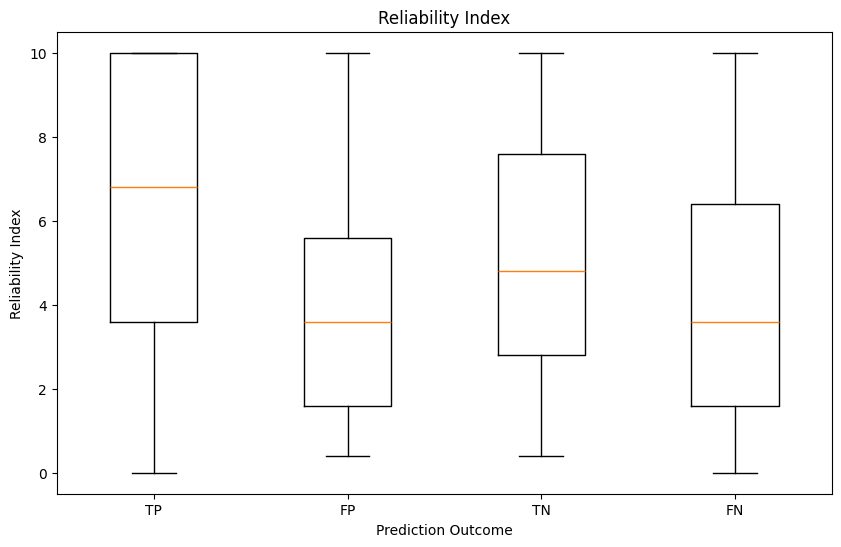

In [20]:
# Train the model
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train_subsampled, y_train_subsampled)

threshold = 0.42

# Get prediction probabilities
predictions = rf_model.predict_proba(X_test)
y_pred = [1 if p[1] >= threshold else 0 for p in predictions]
# print(y_pred)

phi_threshold = 0.45
scaling_const = 40

# d_score = np.abs(predictions[:, 1] - phi_threshold)
d_score = np.abs(predictions[:, 1] - threshold)
# print(d_score)
reliability_index = np.clip(scaling_const * (d_score), -1, 10)

y_pred = np.array(y_pred)

# get all correctly predicted and incorrectly predicted positive indices
correct_positive_indices = np.where((y_test == '1') & (y_pred == 1))[0]
incorrect_positive_indices = np.where((y_test == '1') & (y_pred == 0))[0]
print(correct_positive_indices.shape, incorrect_positive_indices.shape)

correct_positive_ri = reliability_index[correct_positive_indices]
incorrect_positive_ri = reliability_index[incorrect_positive_indices]

correct_negative_indices = np.where((y_test == '0') & (y_pred == 0))[0]
incorrect_negative_indices = np.where((y_test == '0') & (y_pred == 1))[0]
print(correct_negative_indices.shape, incorrect_negative_indices.shape)

correct_negative_ri = reliability_index[correct_negative_indices]
incorrect_negative_ri = reliability_index[incorrect_negative_indices]

# Do a boxplot of the reliability index for correctly predicted and incorrectly predicted positive samples
plt.figure(figsize=(10, 6))
plt.boxplot([correct_positive_ri, incorrect_positive_ri, correct_negative_ri, incorrect_negative_ri], labels=['TP', 'FP', 'TN', 'FN'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Reliability Index')
plt.title('Reliability Index')
plt.show()

[0.35 0.54 0.6  0.63 0.69 0.7  0.74 0.76 0.76 0.76 0.67]
[6.7, 9.0, 13.5, 8.6, 12.6, 7.8, 10.9, 6.6, 8.1, 4.2, 12.0]


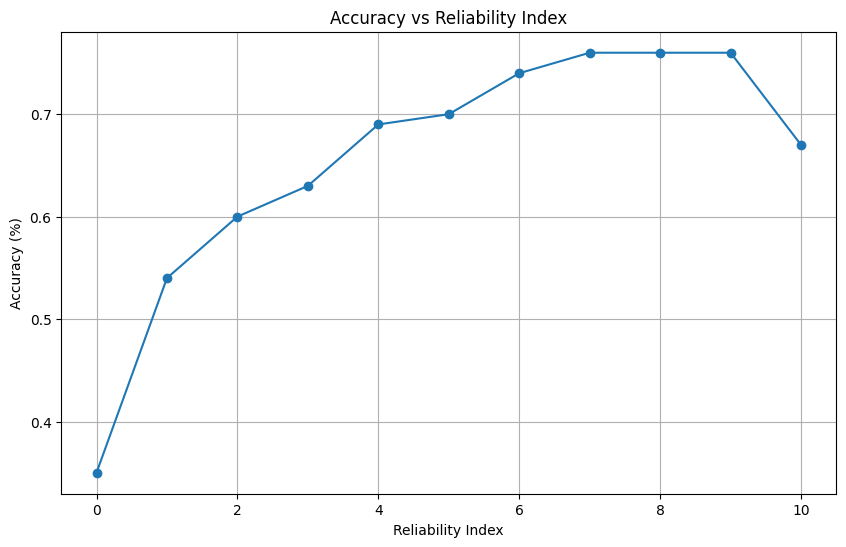

In [21]:
#  Plot a graph of accuracy against reliability index
reliability_index = np.round(np.array(reliability_index))
accuracies = []
ri_sample_percentages = []

for ri in range(0, 11):
    # get all indices in reliability index with score ri
    ri_indices = np.where(reliability_index == ri)[0]
    # get the predictions for these indices
    ri_predictions = np.array(y_pred[ri_indices]).astype(int)
    # get the actual labels for these indices
    ri_actual = np.array(y_test[ri_indices]).astype(int)

    ri_sample_percentages.append(np.round(ri_indices.shape[0] / y_test.shape[0] * 100, 1))
    
    # calculate the accuracy for these indices
    accuracy = accuracy_score(ri_actual, ri_predictions)
    accuracies.append(accuracy)
    
accuracies = np.round(np.array(accuracies), 2)
print(accuracies)
print(ri_sample_percentages)

# for ri in range(0, 11):
#     # get all indices in reliability index with score ri
#     ri_indices = np.where((reliability_index == ri) & (y_test == '1'))[0]
#     # get the predictions for these indices
#     ri_predictions = np.array(y_pred[ri_indices]).astype(int)
#     # get the actual labels for these indices
#     ri_actual = np.array(y_test[ri_indices]).astype(int)

#     ri_sample_percentages.append(np.round(ri_indices.shape[0] / y_test.shape[0] * 100, 1))
    
#     # calculate the accuracy for these indices
#     accuracy = accuracy_score(ri_actual, ri_predictions)
#     accuracies.append(accuracy)
    
# accuracies = np.round(np.array(accuracies), 2)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 11), accuracies, marker = 'o')
plt.title('Accuracy vs Reliability Index')
plt.xlabel('Reliability Index')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# add another x-axis for the percentage of samples in each reliability index